# Problem 2

In [432]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [480]:
#step 1: define log prob
def lnprob(x,mu,sigma):
    return -np.log(np.sqrt(2*np.pi*sigma**2))-(mu-x)**2/(2*sigma**2)

def gauss1d(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def randgen(rng,mid):
    '''random_sample() goes from 0 to 1; this makes it so a full range and midpoint is input'''
    return mid + rng*(np.random.random() - 0.5)


class mcmc:
    
    def __init__(self,nsteps=1000,stepsize=1,x0=0.0):
        self.x0 = x0
        self.stepsize = stepsize
        self.lnpchain = [lnprob(x0,mu,sigma)]
        self.chain = [x0]
        self.nsteps = nsteps
        self.reject = 0.0
    
    #step 2: define proposal density
    def propdensity_linear(self,theta):
        return theta + 2*self.stepsize*(np.random.random()-0.5) #random number from -stepsize to stepsize

    def propdensity_gaussian(self,theta):
        '''actually using this one'''
        return np.random.normal(loc=theta,scale=self.stepsize) #random number in Gaussian around stepsize with sigma = stepsize
    
    #step 4: the guts
    def metro_h(self):
        thetai = self.x0
        for step in range(self.nsteps):
            thetaj = self.propdensity_gaussian(thetai)
            lpi = lnprob(thetai,mu,sigma)
            lpj = lnprob(thetaj,mu,sigma)
            alpha = lpi/lpj
            if alpha >= 1:
                self.chain.append(thetaj)
                self.lnpchain.append(lpj)
                thetai = thetaj
            else:
                r = np.random.random()
                if alpha >= r:
                    self.chain.append(thetaj)
                    self.lnpchain.append(lpj)
                    thetai = thetaj
                else:
                    self.reject += 1.0
                    self.chain.append(thetai)
                    self.lnpchain.append(lpi)
        return self.chain
    
    
    
    def spitstats(self):
        print('Acceptance fraction: '+str(1.0-(self.reject/float(self.nsteps))))
        
        plt.plot(range(self.nsteps+1),self.chain)
        plt.title('Walk path')
        plt.xlabel('Step')
        plt.ylabel('x')
        plt.show()
        plt.close()
        
        plt.plot(range(self.nsteps+1),self.lnpchain)
        plt.title('Probability path')
        plt.xlabel('Step')
        plt.ylabel('P(x)')
        plt.show()
        plt.close()
        
        n,bins,patches = plt.hist(self.chain,50,normed=1)
        
        #best fit line
        #xvals = np.arange(-5*sigma,5*sigma+0.1,0.1)
        #plt.plot(xvals, gauss1d(bins,mu,sigma),color = 'r', linestyle = ':',lw=2)

        # add a 'best fit' line
        z = mlab.normpdf(bins, mu, sigma)
        l = plt.plot(bins, z, 'r--', linewidth=1)
        
        plt.title('Probability Histogram')
        plt.xlabel('x')
        plt.ylabel('Probability')
        plt.show()
            





Acceptance fraction: 0.552


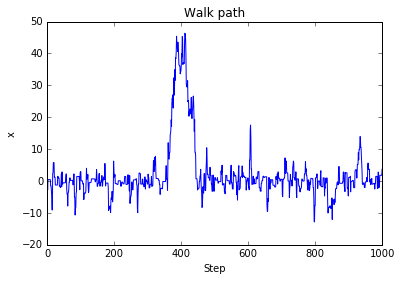

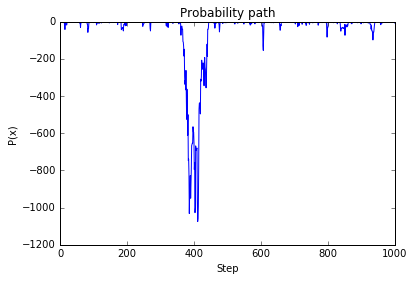

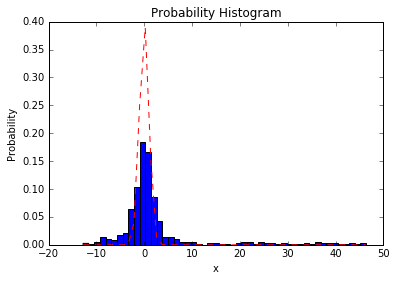

In [482]:
#step 3: starting value
x0 = 3.0
mu = 0.0
sigma = 1


mc = mcmc(nsteps=1000,x0=mu,stepsize=4)
mc.metro_h()
mc.spitstats()

# Problem 3

In [435]:
#import emcee

In [436]:
def model(x,m,b):
    return m*x + b

def fakedata(sigma,sigmax,npts):
    x = np.arange(-10,10+20/npts,20/npts)
    x = np.random.normal(loc=x,scale=sigmax)
    y = model(x,m,b)
    y = np.random.normal(loc=y,scale=sigma)
    return x,y

m = 5.
b = -2.
sigma = 5.
sigmax = 3
npts = 100.

x,y = fakedata(sigma,sigmax,npts)

In [437]:
def lnlike(theta,x,y,sigma):
    return -0.5 * np.sum((y - model(x,theta[0],theta[1]))**2 + np.log(2.*np.pi*sigma**2))

def lnprior(theta):
    if -10 < theta[0] < 10 and -10 < theta[1] < 10:
        return 0.0
    else:
        return -np.inf

def lnprob(theta,x,y,sigma):
    return lnprior(theta) + lnlike(theta,x,y,sigma)

In [438]:
class mcmc2d:
    
    def __init__(self,nsteps=1000,stepxy=(1,1),theta0=(0.0,0.0)):
        self.theta0 = theta0
        self.stepxy = stepxy
        self.lnpchain = [lnprob(theta0,x,y,sigma)]
        self.chain = [theta0]
        self.nsteps = nsteps
        self.accept = [1]
    
    #step 2: define proposal density
    def propdensity_gaussian(self,thetai):
        newx = np.random.normal(loc=thetai[0],scale=self.stepxy[0])
        newy = np.random.normal(loc=thetai[0],scale=self.stepxy[1])
        thetaj = (newx,newy)
        return thetaj #random number in Gaussian around stepsize with sigma = stepsize
    
    #step 4: the guts
    def metro_h(self):
        thetai = self.theta0
        for step in range(self.nsteps):
            thetaj = self.propdensity_gaussian(thetai)
            lpi = lnprob(thetai,x,y,sigma)
            lpj = lnprob(thetaj,x,y,sigma)
            #alpha = np.exp(lpj)/np.exp(lpi)
            alpha = lpi/lpj
            if alpha >= 1:
                self.chain.append(thetaj)
                self.lnpchain.append(lpj)
                thetai = thetaj
                self.accept.append(1)
            else:
                r = np.random.random()
                if alpha >= r:
                    self.chain.append(thetaj)
                    self.lnpchain.append(lpj)
                    thetai = thetaj
                    self.accept.append(1)
                else:
                    self.accept.append(0)
                    self.chain.append(thetai)
                    self.lnpchain.append(lpi)
        return self.chain
    
    def cutchain(self,cutlen):
        self.chain = self.chain[cutlen:]
        self.lnpchain = self.lnpchain[cutlen:]
        self.accept = self.accept[cutlen:]
        return
    
    def spitstats(self):
        acceptdict = {val:self.accept.count(val) for val in self.accept}
        acceptratio = acceptdict[1]/float(len(self.accept))
        print('Acceptance fraction: '+str(acceptratio))
        
        plt.plot(range(len(self.chain)),[val[0] for val in self.chain])
        plt.title('Walk path for x values')
        plt.xlabel('Step')
        plt.ylabel('x')
        plt.show()
        plt.close()
        
        plt.plot(range(len(self.chain)),[val[1] for val in self.chain])
        plt.title('Walk path for y values')
        plt.xlabel('Step')
        plt.ylabel('y')
        plt.show()
        plt.close()        
        
        plt.plot(range(len(self.lnpchain)),self.lnpchain)
        plt.title('Probability path')
        plt.xlabel('Step')
        plt.ylabel('P(theta)')
        plt.show()
        plt.close()

In [439]:
def solutionspace(chain,lnpchain):
    '''Randomly samples the m,b pairs and plots them along with the data and "correct" model'''
    xf,yf = fakedata(sigma,sigmax,npts)

    
    sz = len(chain)
    if sz > 100:
        erase = np.random.choice(range(len(chain)), len(chain)-100, replace=False)
        chain = np.delete(chain,erase,0)
        print(len(chain))
        
    fig = plt.figure(figsize=(10,8))
    
    x = np.arange(-20,22,20)
    for i in range(len(chain)):
        (mi,bi) = chain[i]
        plt.plot(x,model(x,mi,bi),alpha=0.1,color='k')

    data = plt.errorbar(xf,yf,yerr=sigma,linestyle='None',marker = '.')
    real, = plt.plot(x,model(x,m,b),color='r')
    plt.legend([real,data],['Actual','Data'],loc='upper left')    
    
    plt.xlim([-15,15])
    plt.ylabel('y')
    plt.xlabel('x')
    
    plt.show()
    plt.close()

    
    


In [440]:
mc = mcmc2d(nsteps=10000,theta0=(0,0),stepxy=(3,3))
mc.metro_h()

[(0, 0),
 (0, 0),
 (2.312573677484166, 2.7105704222928577),
 (2.312573677484166, 2.7105704222928577),
 (7.3195800411577805, -1.1817917136723657),
 (4.423823690223254, 7.354026697171861),
 (4.98680202280848, 5.4095275504557785),
 (5.484050176025311, 0.25342609807543237),
 (5.484050176025311, 0.25342609807543237),
 (4.930420831908572, 9.30542885066011),
 (8.140452242175524, 8.693730453977743),
 (8.140452242175524, 8.693730453977743),
 (8.140452242175524, 8.693730453977743),
 (6.378918654726014, 8.510710043849132),
 (6.378918654726014, 8.510710043849132),
 (6.378918654726014, 8.510710043849132),
 (4.959586670016835, 3.409421735757885),
 (4.959586670016835, 3.409421735757885),
 (4.959586670016835, 3.409421735757885),
 (4.959586670016835, 3.409421735757885),
 (4.959586670016835, 3.409421735757885),
 (3.1030859251088385, 2.2812383813315322),
 (4.12481343149808, 3.2218792684101554),
 (5.880820790649237, 3.1059784060190623),
 (5.880820790649237, 3.1059784060190623),
 (5.880820790649237, 3.1059

In [441]:
mc.cutchain(500)

Acceptance fraction: 0.483001789285


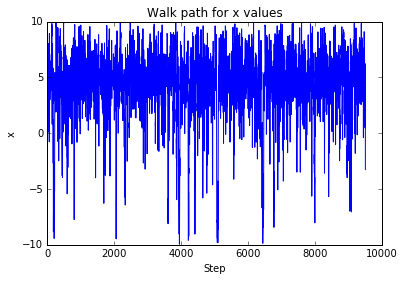

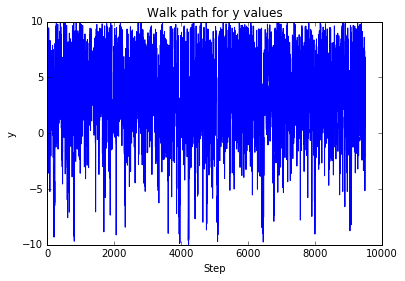

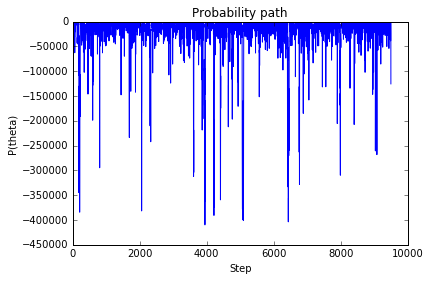

100


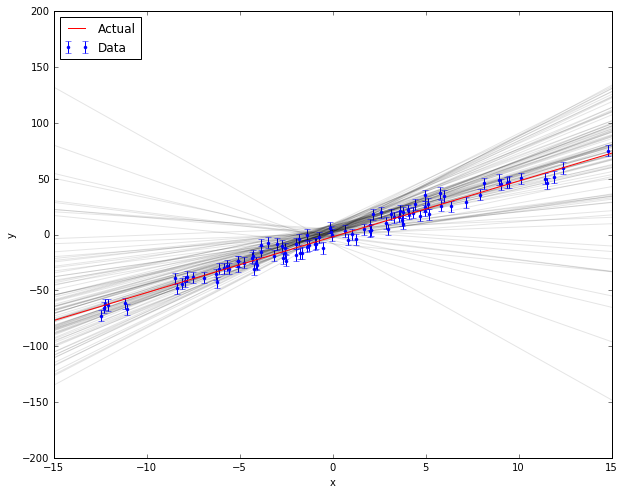

In [442]:
mc.spitstats()

solutionspace(mc.chain,mc.lnpchain)
# Why are my solutions always slightly more positive than they should be?